### Timeseries for the Barents Sea

South (Atlantic side): focus on inflow variability, heat loss to atmosphere, deep mixing, winter heat release.

North (Arctic side): focus on Atlantification trends, stratification weakening, ice loss, freshening/meltwater.

Compare:

Timeseries: OHC, salinity, fluxes (north vs south).

Trends: maps with north–south contrast.

Sections: show how the Polar Front has shifted.

In [1]:
# auto-reload edited modules
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, "/home/mmurakami/crios_backups/an_helper_functions")

# run the script into the current kernel (vars/functions become available)
%run -i "/home/mmurakami/crios_backups/an_helper_functions/load_packages.py"

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [2]:
from itertools import cycle

## Load the two masks we created for S of the polar front and N

In [3]:
# Load later
with np.load("pf_masks_tracer.npz") as data:
    mskS = aste_tracer2compact(data["smask"],nfx,nfy)[0]
    mskS[mskS == 0] = 1
    mskN = aste_tracer2compact(data["nmask"],nfx,nfy)[0]
    cutoff_used  = float(data["cutoff"])  # optional


## Create overall timeseries of the heat and freshwater content from these

In [4]:
# I think we should create a python script to load value and from filename for a 3D or a 2D field
# function should take years, mask, filename, terms I want to load, also the directory

# ocean and ice
AB_gT=0
AB_gS=0
dt_aste = 600
startyr = 2002
endyr = 2019              # for ASTE R1

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)
allyears = np.arange(2006,2018,1)  # start from the beginning of the regime shift

In [5]:
# calculate profiles for the two regions and plot
# do this by looping through the salt and heat -- we want to make an average of these as depth
theta_distN = np.zeros((len(allyears),12,nz))
salt_distN = np.zeros((len(allyears),12,nz))

# for heating and salting portion -- see if this is different
theta_distS = np.zeros((len(allyears),12,nz))
salt_distS = np.zeros((len(allyears),12,nz))

# do indexing in years for the layers
iy = 0
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    ##########################################################################################
    # get the theta/salt values
    # we also want salt to do the FW content
    # we want temperature and salt
    THETADR = np.full((len(tsstr),nz,ny,nx),np.nan)
    SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'budg3d_snap_set2'
        meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_budg3d_snap_set2["fldList"])
        varnames = np.array(["THETADR","SALTDR"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
            
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        THETADRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
        SALTDRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[1])  # degC.m
    
        THETADR[i,:,:,:] = np.reshape(THETADRi,(nz,ny,nx))
        SALTDR[i,:,:,:] = np.reshape(SALTDRi,(nz,ny,nx))

    for i in range(len(datetimes)):
        # for calculating heat content:
            # weighted theta * rcp = J/m^2 which is the depth-weighted heat content of a cell
            # integrate over all values within the depth interval of choice
        # do the depth meaning for theta
        thisTHETA = THETADR[i]/DRF3d/hfC * np.tile(mskN[np.newaxis,:,:],(nz,1,1))    # degC
        thisTHETA[thisTHETA == 0] = np.nan   # this was messing up averaging without this precaution
        theta_distN[iy,i,:] = np.nanmean(thisTHETA, axis = (1,2))  # depth average of shape nz
        thisTHETA = THETADR[i]/DRF3d/hfC * np.tile(mskS[np.newaxis,:,:],(nz,1,1))    # degC
        thisTHETA[thisTHETA == 0] = np.nan
        theta_distS[iy,i,:] = np.nanmean(thisTHETA, axis = (1,2))

        # do the depth averaging for freshwater
        thisSALT = SALTDR[i]/DRF3d/hfC * np.tile(mskN[np.newaxis,:,:],(nz,1,1))    # PSU
        thisSALT[thisSALT == 0] = np.nan
        salt_distN[iy,i,:] = np.nanmean(thisSALT, axis = (1,2))  # depth average of shape nz
        thisSALT = SALTDR[i]/DRF3d/hfC * np.tile(mskS[np.newaxis,:,:],(nz,1,1))    # PSU
        thisSALT[thisSALT == 0] = np.nan
        salt_distS[iy,i,:] = np.nanmean(thisSALT, axis = (1,2))

    iy += 1

2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


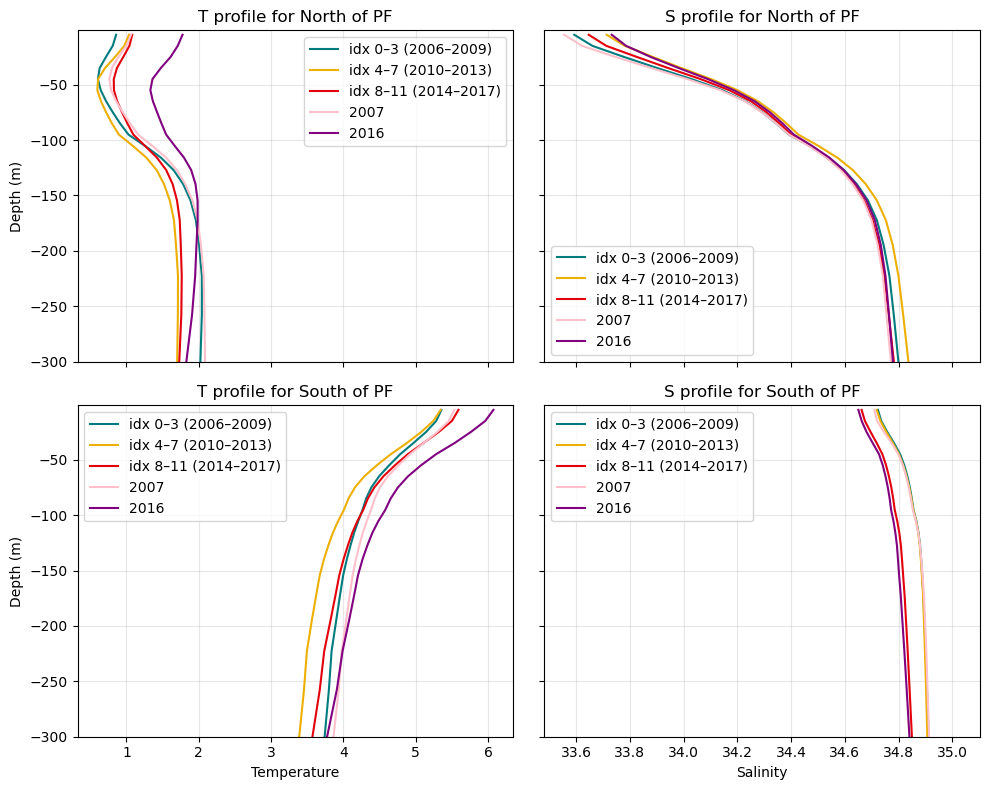

In [6]:

# group size
d = 4
years = np.asarray(allyears, dtype=int)

# make chunk edges: [(0,d), (d,2d), ..., (last chunk)]
edges = [(i, min(i+d, len(years))) for i in range(0, len(years), d)]

# colors (cycle if more chunks than colors)
c1, c2, c3 = '#007c7e', '#edaf02', '#e3010c'
color_cycle = [c1, c2, c3]

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex='col', sharey=True)

for k, (i0, i1) in enumerate(edges):
    col = color_cycle[k % len(color_cycle)]

    # labels — show indices, and also years for clarity
    lab = f"idx {i0}–{i1-1} ({years[i0]}–{years[i1-1]})"
    # if you only want indices, use: lab = f"idx {i0}–{i1-1}"
    # if you only want years,   use: lab = f"{years[i0]}–{years[i1-1]}"

    # North of PF
    axes[0, 0].plot(np.nanmean(theta_distN[i0:i1], axis=(0, 1)), mygrid['RC'], label=lab, color=col)
    axes[0, 1].plot(np.nanmean(salt_distN[i0:i1],  axis=(0, 1)), mygrid['RC'], label=lab, color=col)


    # South of PF
    axes[1, 0].plot(np.nanmean(theta_distS[i0:i1], axis=(0, 1)), mygrid['RC'], label=lab, color=col)
    axes[1, 1].plot(np.nanmean(salt_distS[i0:i1],  axis=(0, 1)), mygrid['RC'], label=lab, color=col)

#also plot specifically for 2007 and 2016
axes[0, 0].plot(np.nanmean(theta_distN[1], axis=(0)), mygrid['RC'], label="2007", color="pink")
axes[0, 1].plot(np.nanmean(salt_distN[1],  axis=(0)), mygrid['RC'], label="2007", color="pink")
axes[0, 0].plot(np.nanmean(theta_distN[10], axis=(0)), mygrid['RC'], label="2016", color="purple")
axes[0, 1].plot(np.nanmean(salt_distN[10],  axis=(0)), mygrid['RC'], label="2016", color="purple")
axes[1, 0].plot(np.nanmean(theta_distS[1], axis=(0)), mygrid['RC'], label="2007", color="pink")
axes[1, 1].plot(np.nanmean(salt_distS[1],  axis=(0)), mygrid['RC'], label="2007", color="pink")
axes[1, 0].plot(np.nanmean(theta_distS[10], axis=(0)), mygrid['RC'], label="2016", color="purple")
axes[1, 1].plot(np.nanmean(salt_distS[10],  axis=(0)), mygrid['RC'], label="2016", color="purple")

# styling
for ax in axes.ravel():
    ax.set_ylim(-300, -1)
    ax.grid(alpha=0.3)
    ax.legend()

axes[0, 0].set_title("T profile for North of PF")
axes[0, 1].set_title("S profile for North of PF")
axes[1, 0].set_title("T profile for South of PF")
axes[1, 1].set_title("S profile for South of PF")

axes[1, 0].set_xlabel("Temperature")
axes[1, 1].set_xlabel("Salinity")
axes[0, 0].set_ylabel("Depth (m)")
axes[1, 0].set_ylabel("Depth (m)")

plt.tight_layout()
plt.show()


## let's also load the upper ocean heat and freshwater content for the two years

In [64]:
dterm = 10 # for 100m

In [72]:
# --- single C-grid mask from mymsk (NaN outside)
msk_C = mymsk

# 3D area for thickness conversion
RAC3 = np.broadcast_to(RAC[None, :, :], (nz, ny, nx))

# Output arrays (single mask; two depth layers)
heat_top  = np.full((len(allyears), 12, ny, nx), np.nan)  # J,  z: 0..dterm-1
heat_deep = np.full((len(allyears), 12, ny, nx), np.nan)  # J,  z: dterm..nz-1
fw_top    = np.full((len(allyears), 12, ny, nx), np.nan)  # m,  z: 0..dterm-1
fw_deep   = np.full((len(allyears), 12, ny, nx), np.nan)  # m,  z: dterm..nz-1

# Indices into fldList (discover once)
rec_ETAN = rec_THETADR = rec_SALTDR = None

sref = 34.8  # PSU
iy = 0
for year in allyears:
    print(int(year))

    # --- monthly timesteps for this year
    times = {str(int(year)): np.arange(1, 13, 1)}
    tsstr, datetimes = get_tsteps(times, fnames, dt_aste, startyr, 1, 1)
    nT = len(tsstr)
    if nT == 0:
        print("  No timesteps found; skipping.")
        iy += 1
        continue

    # --- discover record indices once
    if rec_ETAN is None:
        meta2d = parsemeta(os.path.join(dirIn, f"budg2d_snap_set1.{tsstr[0]}.meta"))
        fld2d  = np.array(meta2d['fldList'])
        rec_ETAN = int(np.where(fld2d == 'ETAN')[0][0])

        meta3d = parsemeta(os.path.join(dirIn, f"budg3d_snap_set2.{tsstr[0]}.meta"))
        fld3d  = np.array(meta3d['fldList'])
        rec_THETADR = int(np.where(fld3d == 'THETADR')[0][0])
        rec_SALTDR  = int(np.where(fld3d == 'SALTDR')[0][0])

    # --- allocate and READ ONCE per year ---
    vol     = np.full((nT, nz, ny, nx), np.nan, dtype=float)  # m^3
    THETADR = np.full((nT, nz, ny, nx), np.nan, dtype=float)  # degC*m
    SALTDR  = np.full((nT, nz, ny, nx), np.nan, dtype=float)  # PSU*m

    # volume from ETAN (2D → 3D per your logic)
    for ti, ts in enumerate(tsstr):
        read = [int(ts)]
        ETAN, its, _ = rdmds(os.path.join(dirIn, 'budg2d_snap_set1'),
                             read, returnmeta=True, rec=rec_ETAN)
        ETAN = np.reshape(ETAN, (ny, nx))

        tmpvol = np.zeros((nz, ny, nx), dtype=float)
        if myparms['useNLFS'] < 2 or myparms['rStar'] == 0:
            tmpvol[0, :, :] = ETAN * myparms['rhoconst'] * RAC
            if myparms['useRFWF'] == 0:
                tmpvol[0, :, :] = 0.0
        else:
            # r* branch (retain your original logic/vars)
            if myparms['useRFWF'] != 0:
                tmp1 = mk3D_mod(mygrid['DRF'], mygrid['hFacC']) * mygrid['hFacC']  # m
                tmp2 = tmp1 / mk3D_mod(DD, tmp1)
            else:
                tmp2 = drf3d / mk3D_mod(DD, tmp1)
            tmpvol = (tmp1 + tmp2 * mk3D_mod(ETAN, tmp2))

        vol[ti] = tmpvol

    # THETADR & SALTDR (3D)
    for ti, ts in enumerate(tsstr):
        read = [int(ts)]
        Tdr, its, _ = rdmds(os.path.join(dirIn, 'budg3d_snap_set2'),
                            read, returnmeta=True, rec=rec_THETADR)
        Sdr, its, _ = rdmds(os.path.join(dirIn, 'budg3d_snap_set2'),
                            read, returnmeta=True, rec=rec_SALTDR)
        THETADR[ti] = np.reshape(Tdr, (nz, ny, nx))
        SALTDR[ti]  = np.reshape(Sdr, (nz, ny, nx))

    # recover THETA, SALT safely (use nT, not hard-coded 12)
    THETA = np.full_like(THETADR, np.nan)
    SALT  = np.full_like(SALTDR,  np.nan)
    valid3 = (mygrid['hFacC'] > 0) & np.isfinite(DRF3d)
    valid3 = np.tile(valid3[None, :, :, :], (nT, 1, 1, 1))
    DRF3d2 = np.tile(DRF3d[None, :, :, :], (nT, 1, 1, 1))
    hfC2   = np.tile(mygrid['hFacC'][None, :, :, :], (nT, 1, 1, 1))
    THETA[valid3] = THETADR[valid3] / (DRF3d2[valid3] * hfC2[valid3])
    SALT[valid3]  = SALTDR[valid3]  / (DRF3d2[valid3] * hfC2[valid3])

    # --- depth slices
    top_slice  = slice(0, dterm)   # 0..dterm-1
    deep_slice = slice(dterm, nz)  # dterm..nz-1

    for ti in range(nT):
        theta_here = THETA[ti]  # (nz, ny, nx)
        salt_here  = SALT[ti]
        vol_here   = vol[ti]    # (nz, ny, nx)

        # Heat content per layer: theta[°C] * rcp[J m^-3 K^-1] * vol[m^3] -> J
        heat_J_layers = (theta_here * myparms['rcp']) * vol_here

        # FW thickness per layer: (vol * (1 - S/sref)) / area -> m
        FWvol_layers = vol_here * (1.0 - salt_here / sref)  # m^3
        FWthk_layers = FWvol_layers / RAC3                  # m

        # split at dterm
        heat_top_layers  = heat_J_layers[top_slice]
        heat_deep_layers = heat_J_layers[deep_slice]
        fw_top_layers    = FWthk_layers[top_slice]
        fw_deep_layers   = FWthk_layers[deep_slice]

        # apply mask and sum over z
        heat_top[iy, ti]  = np.nansum(heat_top_layers  * msk_C, axis=0)  # (ny, nx) J
        heat_deep[iy, ti] = np.nansum(heat_deep_layers * msk_C, axis=0)  # (ny, nx) J
        fw_top[iy, ti]    = np.nansum(fw_top_layers    * msk_C, axis=0)  # (ny, nx) m
        fw_deep[iy, ti]   = np.nansum(fw_deep_layers   * msk_C, axis=0)  # (ny, nx) m

    iy += 1

# ---- optional: save to disk
# outdir = "/path/to/save"
# np.savez(os.path.join(outdir, f"BS_singlemask_top_d{dterm}.npz"),
#          heat_top=heat_top, fw_top=fw_top, allyears=np.asarray(allyears), dterm=np.int32(dterm))
# np.savez(os.path.join(outdir, f"BS_singlemask_deep_from_{dterm}.npz"),
#          heat_deep=heat_deep, fw_deep=fw_deep, allyears=np.asarray(allyears), dterm=np.int32(dterm))


2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


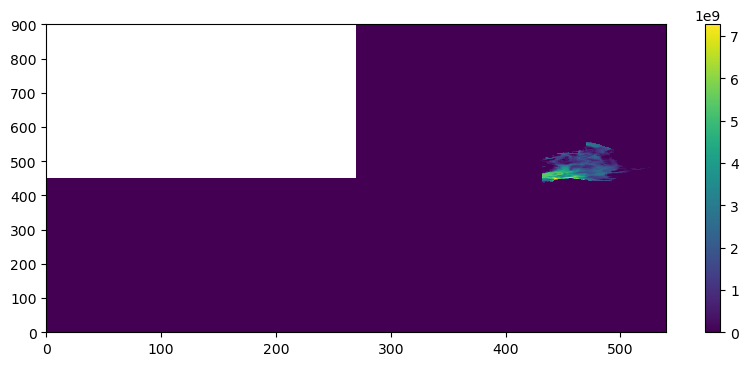

In [80]:
plt.pcolormesh(get_aste_tracer(heat_deep[0][0],nfx,nfy)[0])
plt.colorbar()

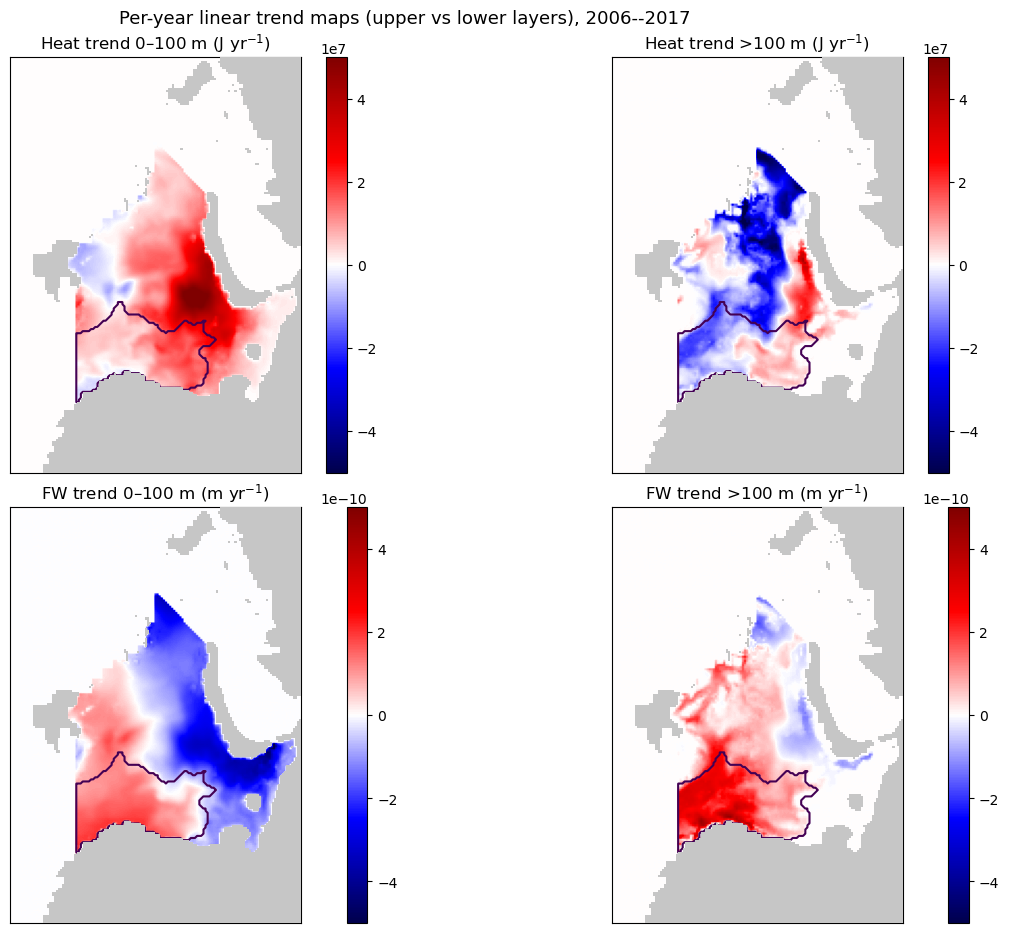

In [91]:
years = np.asarray(allyears, dtype=float)  # (nyears,)

def annualize(maps_yr_mon, how='mean'):
    """(nyears,12,ny,nx) → (nyears,ny,nx)."""
    if how == 'mean': return np.nanmean(maps_yr_mon, axis=1)
    if how == 'sum':  return np.nansum(maps_yr_mon, axis=1)
    raise ValueError("how must be 'mean' or 'sum'")

def slope_per_year(Y, xyears):
    """
    Linear trend (least-squares slope) along time axis.
    Y: (Ny, ny, nx), xyears: (Ny,) -> (ny, nx) in units of Y per year.
    """
    X = xyears.astype(float)[:, None, None]
    M = np.isfinite(Y)
    n   = np.sum(M, axis=0)
    Sx  = np.sum(np.where(M, X, 0), axis=0)
    Sy  = np.sum(np.where(M, Y, 0), axis=0)
    Sxx = np.sum(np.where(M, X*X, 0), axis=0)
    Sxy = np.sum(np.where(M, X*Y, 0), axis=0)
    denom = n*Sxx - Sx*Sx
    slope = np.full_like(denom, np.nan, dtype=float)
    good = (denom != 0) & (n >= 2)
    slope[good] = (n[good]*Sxy[good] - Sx[good]*Sy[good]) / denom[good]
    return slope

def sym_vlim(*arrays, pct=98):
    vals = np.concatenate([a[np.isfinite(a)].ravel() for a in arrays if a is not None])
    if vals.size == 0: return (-1, 1)
    vmax = np.nanpercentile(np.abs(vals), pct)
    return (-vmax, vmax)

def to_aste(a2d):
    return get_aste_tracer(a2d, nfx, nfy)[0]

# 1) Annual fields (use 'mean'; if you truly want annual totals for heat, switch to 'sum')
H_u_ann = annualize(heat_top, how='mean')   # (Ny,ny,nx) J
H_b_ann = annualize(heat_deep, how='mean')   # (Ny,ny,nx) J
F_u_ann = annualize(fw_top,   how='mean')   # (Ny,ny,nx) m
F_b_ann = annualize(fw_deep,   how='mean')   # (Ny,ny,nx) m

# 2) Per-year linear trends
H_u_tr = slope_per_year(H_u_ann, years)  # J/yr
H_b_tr = slope_per_year(H_b_ann, years)  # J/yr
F_u_tr = slope_per_year(F_u_ann, years)  # m/yr
F_b_tr = slope_per_year(F_b_ann, years)  # m/yr

# 3) Map to ASTE plotting arrays
Hu = to_aste(H_u_tr); Hb = to_aste(H_b_tr)
Fu = to_aste(F_u_tr); Fb = to_aste(F_b_tr)

# 4) Plot 2×2 with symmetric color limits per variable
vmin_h, vmax_h = sym_vlim(H_u_tr, H_b_tr, pct=98)
vmin_f, vmax_f = sym_vlim(F_u_tr, F_b_tr, pct=98)

fig, axs = plt.subplots(2, 2, figsize=(12, 9), constrained_layout=True)

cmap_h = plt.cm.RdBu_r; cmap_h.set_bad('lightgray', 0.5)
cmap_f = plt.cm.RdBu_r; cmap_f.set_bad('lightgray', 0.5)

im00 = axs[0,0].imshow(Hu, origin='lower', vmin=-5e7, vmax=5e7, cmap='seismic')
axs[0,0].set_title("Heat trend 0–100 m (J yr$^{-1}$)")
fig.colorbar(im00, ax=axs[0,0], fraction=0.046, pad=0.04)

im01 = axs[0,1].imshow(Hb, origin='lower', vmin=-5e7, vmax=5e7, cmap='seismic')
axs[0,1].set_title("Heat trend >100 m (J yr$^{-1}$)")
fig.colorbar(im01, ax=axs[0,1], fraction=0.046, pad=0.04)

im10 = axs[1,0].imshow(Fu, origin='lower', vmin=-5e-10, vmax=5e-10, cmap='seismic')
axs[1,0].set_title("FW trend 0–100 m (m yr$^{-1}$)")
fig.colorbar(im10, ax=axs[1,0], fraction=0.046, pad=0.04)

im11 = axs[1,1].imshow(Fb, origin='lower', vmin=-5e-10, vmax=5e-10, cmap='seismic')
axs[1,1].set_title("FW trend >100 m (m yr$^{-1}$)")
fig.colorbar(im11, ax=axs[1,1], fraction=0.046, pad=0.04)

for ax in axs.flat:
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlim(400,540)
    ax.set_ylim(400,600)
    ax.pcolormesh(get_aste_tracer(landmsk, nfx, nfy)[0],cmap="Greys", zorder=7, vmin=0, vmax=6)

    # also plot on this a faint outline of the mskS
    ax.contour(get_aste_tracer(mskS,nfx,nfy)[0],levels=[0.9])

plt.suptitle("Per-year linear trend maps (upper vs lower layers), 2006--2017", y=1.02, fontsize=13)
plt.show()


In [90]:
mskS[np.isnan(mskS)] = 0

# plot the heat content trend as a per-year map for upper 100m and 100m+ for AW layer

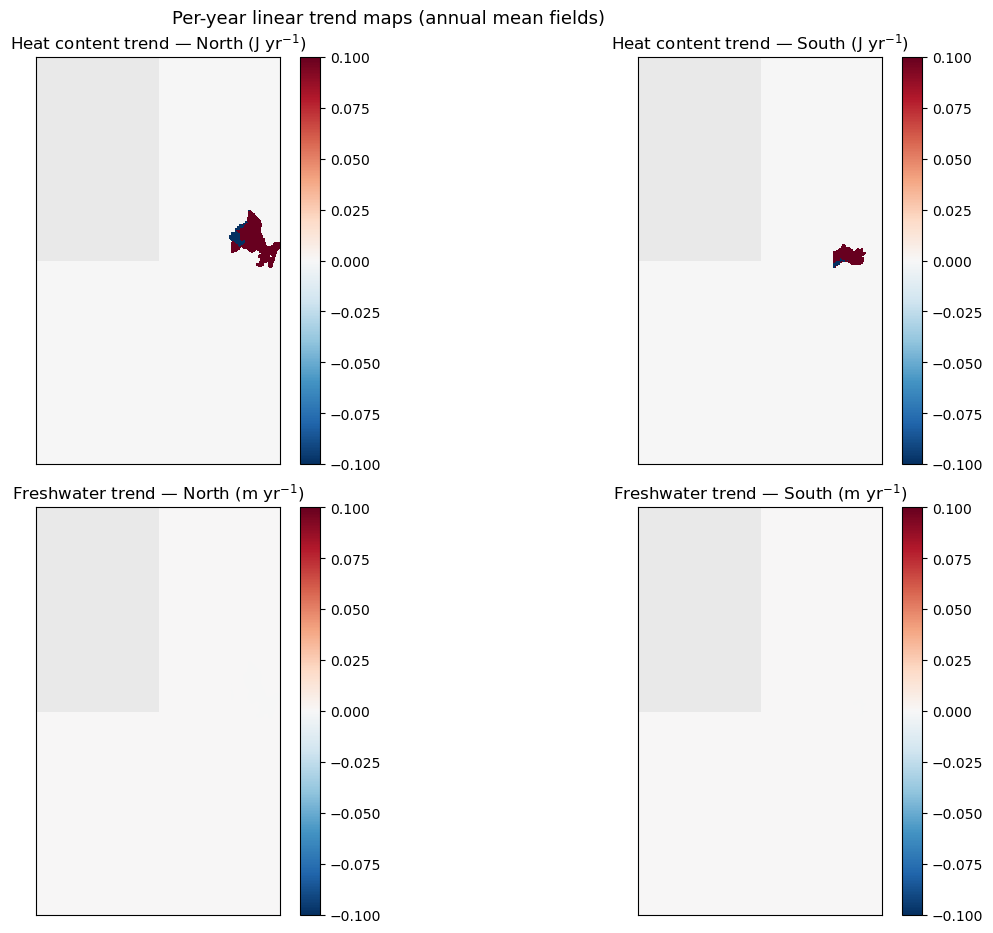

In [66]:

# --- choose which set to visualize (upto or plus) ---
# HC = heat_content_upto
# FW = fw_content_upto
# or:
# HC = heat_content_plus
# FW = fw_content_plus
HC = heat_content   # <- if you already bound one of the above to this name
FW = fw_content

years = np.asarray(allyears, dtype=float)  # shape (Ny,)

def annualize(maps_yr_mon, how='mean'):
    """
    (nyears, 12, ny, nx) -> (nyears, ny, nx)
    how='mean' is appropriate for state-like content; use 'sum' if you truly want annual totals.
    """
    if how == 'mean':
        return np.nanmean(maps_yr_mon, axis=1)
    elif how == 'sum':
        return np.nansum(maps_yr_mon, axis=1)
    else:
        raise ValueError("how must be 'mean' or 'sum'")

def slope_per_year(Y, xyears):
    """
    Vectorized least-squares slope along time.
    Y: (Ny, ny, nx)  per-year values
    xyears: (Ny,)    year numbers (e.g., 2006..2020)
    returns: (ny, nx) slope per year (units of Y per year)
    """
    X = xyears.astype(float)
    X2 = X[:, None, None]
    M = np.isfinite(Y)

    n   = np.sum(M, axis=0)                         # (ny, nx)
    Sx  = np.sum(np.where(M, X2, 0.0), axis=0)
    Sy  = np.sum(np.where(M, Y,  0.0), axis=0)
    Sxx = np.sum(np.where(M, X2*X2, 0.0), axis=0)
    Sxy = np.sum(np.where(M, X2*Y,  0.0), axis=0)

    denom = n * Sxx - Sx * Sx
    slope = np.full_like(denom, np.nan, dtype=float)
    good  = (denom != 0) & (n >= 2)
    slope[good] = (n[good] * Sxy[good] - Sx[good] * Sy[good]) / denom[good]
    return slope

def sym_vlim(*arrays, pct=98):
    vals = np.concatenate([a[np.isfinite(a)].ravel() for a in arrays if a is not None])
    if vals.size == 0:
        return (-1, 1)
    vmax = np.nanpercentile(np.abs(vals), pct)
    return (-vmax, vmax)

def to_aste(field2d):
    """Use user's helper to get a plotting-ready tracer array."""
    return get_aste_tracer(field2d, nfx, nfy)[0]

# --- compute annual fields and linear trends (per year) ---
# Use 'mean' since heat_content / fw_content are state-like maps per month.
ann_heat_N = annualize(HC["N"], how='mean')   # (Ny, ny, nx)
ann_heat_S = annualize(HC["S"], how='mean')
ann_fw_N   = annualize(FW["N"], how='mean')
ann_fw_S   = annualize(FW["S"], how='mean')

trend_heat_N = slope_per_year(ann_heat_N, years)   # J / year
trend_heat_S = slope_per_year(ann_heat_S, years)
trend_fw_N   = slope_per_year(ann_fw_N,   years)   # m / year
trend_fw_S   = slope_per_year(ann_fw_S,   years)

# Map to ASTE plotting arrays
Hn = to_aste(trend_heat_N)
Hs = to_aste(trend_heat_S)
Fn = to_aste(trend_fw_N)
Fs = to_aste(trend_fw_S)

# Color limits (common within variable)
vmin_h, vmax_h = sym_vlim(trend_heat_N, trend_heat_S, pct=98)
vmin_f, vmax_f = sym_vlim(trend_fw_N,   trend_fw_S,   pct=98)

# --- plot 2x2 ---
fig, axs = plt.subplots(2, 2, figsize=(12, 9), constrained_layout=True)

# Optional: nice diverging colormap with NaN as light gray
cmap_h = plt.cm.RdBu_r
cmap_f = plt.cm.RdBu_r
cmap_h.set_bad('lightgray', 0.5)
cmap_f.set_bad('lightgray', 0.5)

im00 = axs[0,0].imshow(Hn, origin='lower', vmin=vmin_h, vmax=vmax_h, cmap=cmap_h)
axs[0,0].set_title("Heat content trend — North (J yr$^{-1}$)")
fig.colorbar(im00, ax=axs[0,0], fraction=0.046, pad=0.04)

im01 = axs[0,1].imshow(Hs, origin='lower', vmin=vmin_h, vmax=vmax_h, cmap=cmap_h)
axs[0,1].set_title("Heat content trend — South (J yr$^{-1}$)")
fig.colorbar(im01, ax=axs[0,1], fraction=0.046, pad=0.04)

im10 = axs[1,0].imshow(Fn, origin='lower', vmin=vmin_f, vmax=vmax_f, cmap=cmap_f)
axs[1,0].set_title("Freshwater trend — North (m yr$^{-1}$)")
fig.colorbar(im10, ax=axs[1,0], fraction=0.046, pad=0.04)

im11 = axs[1,1].imshow(Fs, origin='lower', vmin=vmin_f, vmax=vmax_f, cmap=cmap_f)
axs[1,1].set_title("Freshwater trend — South (m yr$^{-1}$)")
fig.colorbar(im11, ax=axs[1,1], fraction=0.046, pad=0.04)

for ax in axs.flat:
    ax.set_xticks([]); ax.set_yticks([])

plt.suptitle("Per-year linear trend maps (annual mean fields)", y=1.02, fontsize=13)
plt.show()


## also add the SI extent to the plot below (will be overall on the mask)

2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


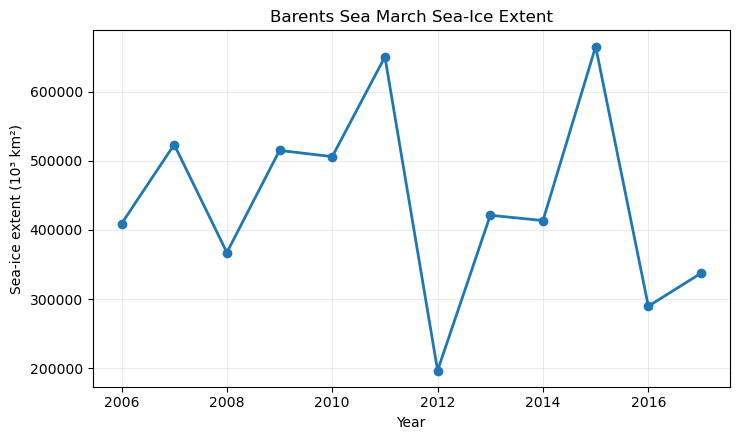

In [26]:
# --- build SIareas: only March (index 2) kept; others set to NaN ---
alldatetimes = np.array([])
SIareas = np.zeros((len(allyears), 12)) * np.nan  # prefill with NaN

iy = 0
for year in allyears:
    print(year)

    years = np.array([str(year)])
    times = {str(year): np.arange(1, 13, 1)}  # all months for that year

    tsstr, datetimes = get_tsteps(times, fnames, dt_aste, startyr, 1, 1)

    SIarea = np.full((len(tsstr), ny, nx), np.nan)  # m^2 field per month

    for i in range(len(tsstr)):
        # read fractional SIarea and convert to m^2
        file_name = 'state_2d_set1'
        meta_state_2d_set1 = parsemeta(dirState + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_state_2d_set1["fldList"])
        varnames = np.array(["SIarea"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])

        read = [int(tsstr[i])]
        SIareai, its, meta = rdmds(os.path.join(dirState, file_name),
                                   read, returnmeta=True, rec=recs[0])  # m^2/m^2
        SIarea[i, :, :] = np.reshape(SIareai, (ny, nx)) * mymsk * RAC  # now m^2

        # keep only March (index 2) and store as 10^3 km^2
        if i == 2:
            SIareas[iy, i] = np.nansum(SIarea[i, :, :]) * 1e-6  # m^2 -> 10^3 km^2
        else:
            SIareas[iy, i] = np.nan

    iy += 1

# --- extract March-only series across years and plot ---
SI_march = SIareas[:, 2]  # one value per year, units: 10^3 km^2
years = np.asarray(allyears)

# guard against NaNs if any year was missing March
mask = np.isfinite(SI_march)
years_plot = years[mask]
SI_march_plot = SI_march[mask]

plt.figure(figsize=(7.5, 4.5))
plt.plot(years_plot, SI_march_plot, marker='o', lw=2)
plt.title("Barents Sea March Sea-Ice Extent")
plt.xlabel("Year")
plt.ylabel("Sea-ice extent (10³ km²)")
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


In [29]:
Tsi = np.arange(0,144,12)
Tsi.shape

(12,)

-0.3333333333333333


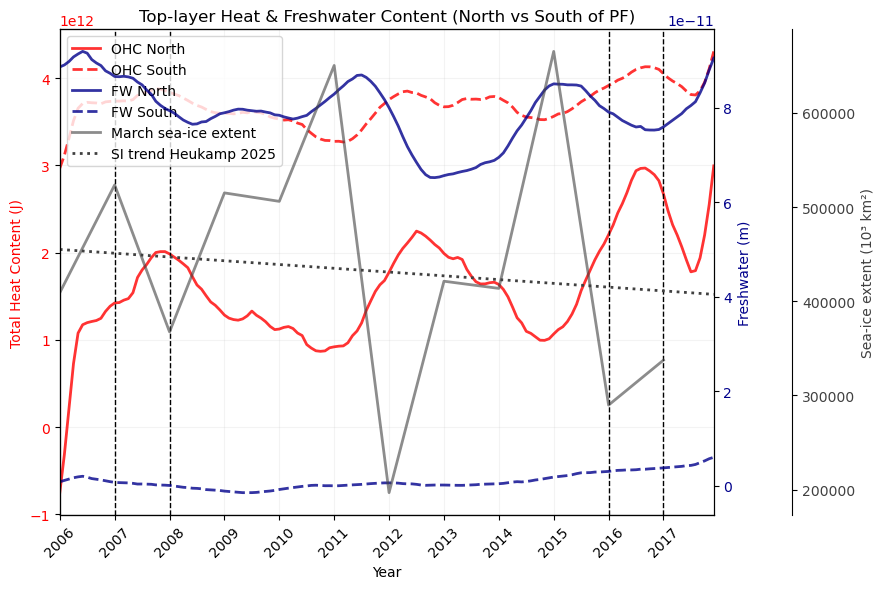

In [52]:
# Assumes you have (from earlier steps):
# heat_content["N"], heat_content["S"]  -> shape (nyears, 12, ny, nx), units: J per cell (already vertically integrated)
# fw_content["N"],   fw_content["S"]    -> shape (nyears, 12, ny, nx), units: m thickness per cell
# allyears (list/array of years)
# RAC (ny, nx)  -- only needed if you want area-weighted means or FW volumes

def series_from_maps(maps_yr_mon, how="sum", area=None):
    """
    Convert (nyears, 12, ny, nx) maps into a 1D monthly time series.
    how:
      - "sum": sum over space each month (e.g., total J over region for heat)
      - "area_mean": area-weighted mean over space each month (needs area)
      - "volume": sum(area * field) each month (e.g., FW volume in m^3; needs area)
    """
    tmap = maps_yr_mon.reshape(-1, maps_yr_mon.shape[-2], maps_yr_mon.shape[-1])  # (T, ny, nx)
    if how == "sum":
        return np.nansum(tmap, axis=(1, 2))
    elif how == "area_mean":
        if area is None: raise ValueError("area is required for area_mean")
        num = np.nansum(tmap * area[None, :, :], axis=(1, 2))
        den = np.nansum(np.where(np.isfinite(tmap), area[None, :, :], 0.0), axis=(1, 2))
        return num / np.where(den > 0, den, np.nan)
    elif how == "volume":
        if area is None: raise ValueError("area is required for volume")
        return np.nansum(tmap * area[None, :, :], axis=(1, 2))
    else:
        raise ValueError("Unknown 'how'")

# --- choose how you want the reduction over space ---
# For heat: total J over region makes sense -> "sum"
# For FW: mean thickness ("area_mean") OR total volume ("volume")
heat_how = "sum"
fw_how   = "area_mean"  # or "volume"

# Build monthly time series for both regions
heat_N = series_from_maps(heat_content["N"], how=heat_how, area=RAC)
heat_S = series_from_maps(heat_content["S"], how=heat_how, area=RAC)

fw_N   = series_from_maps(fw_content["N"],   how=fw_how,   area=RAC)
fw_S   = series_from_maps(fw_content["S"],   how=fw_how,   area=RAC)

# Smooth with 12-month rolling mean
window_size = 12
heat_N_sm = pd.Series(heat_N).rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()
heat_S_sm = pd.Series(heat_S).rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()
fw_N_sm   = pd.Series(fw_N).rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()
fw_S_sm   = pd.Series(fw_S).rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()

# Time axis from allyears
nyears = len(allyears); T = nyears * 12
time = np.arange(T)                          # monthly index
xtick_positions = np.arange(0, T, 12)        # every January
xtick_labels = np.asarray(allyears, dtype=int)

# Plot
fig, ax1 = plt.subplots(figsize=(9, 6))

# Heat (left axis): North solid, South dashed
ax1.plot(time, heat_N_sm, color="red", alpha=.8, lw=2, label="OHC North")
ax1.plot(time, heat_S_sm, color="red", alpha=.8, lw=2, ls="--", label="OHC South")
ax1.set_ylabel("Total Heat Content (J)", color="red")  # change to MJ/m² if you normalize by area
ax1.tick_params(axis='y', labelcolor="red")

# FW (right axis): North solid, South dashed
ax2 = ax1.twinx()
ax2.plot(time, fw_N_sm, color="darkblue", alpha=.8, lw=2, label="FW North")
ax2.plot(time, fw_S_sm, color="darkblue", alpha=.8, lw=2, ls="--", label="FW South")
ax2.set_ylabel("Freshwater (m)" if fw_how=="area_mean" else "Freshwater Volume (m³)", color="darkblue")
ax2.tick_params(axis='y', labelcolor="darkblue")

# Axes cosmetics
ax1.set_xlabel("Year")
ax1.set_title("Top-layer Heat & Freshwater Content (North vs South of PF)")
ax1.set_xticks(xtick_positions)
ax1.set_xticklabels(xtick_labels, rotation=45)
ax1.set_xlim(0, T-1)
ax1.grid(alpha=0.15)

# # Equations (optional)
# eq1 = r"$F = \frac{S_{r} - S}{S_{r}}$"
# eq2 = r"$H = \rho C_p (T - T_{r})$"
# eq3 = r"$\bar{x}_i = \frac{1}{N} \sum_{j=i-k}^{i+k} x_j$"
# ax1.text(0.32, 0.92, eq1, transform=ax1.transAxes, fontsize=12, va='top', color='black')
# ax1.text(0.32, 0.85, eq2, transform=ax1.transAxes, fontsize=12, va='top', color='black')
# ax1.text(0.21, 0.76, "rolling average:", transform=ax1.transAxes, fontsize=12, va='top', color='black')
# ax1.text(0.32, 0.72, eq3, transform=ax1.transAxes, fontsize=12, va='top', color='black')

# add the vertical lines for the years of interest that we have
# Find month indices for 2007 and 2016
year0 = 2006
x2007 = (2007 - year0) * 12   # = 12
x2008 = (2008 - year0) * 12   # = 12
x2016 = (2016 - year0) * 12   # = 120
x2017 = (2017 - year0) * 12   # = 120
# Add dashed lines for 2007 and 2016
ax1.axvline(x2007, color="k", linestyle="--", linewidth=1)
ax1.axvline(x2016, color="k", linestyle="--", linewidth=1)
ax1.axvline(x2008, color="k", linestyle="--", linewidth=1)
ax1.axvline(x2017, color="k", linestyle="--", linewidth=1)

# add the sea ice extent as well on this

# --- Sea ice extent on a third axis (far right) ---
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.12))   # push the third axis out a bit
ax3.plot(Tsi, SI_march_plot, lw=2, alpha=.6, color="0.25", label="March sea-ice extent")
ax3.set_ylabel("Sea-ice extent (10³ km²)", color="0.25")
ax3.tick_params(axis='y', labelcolor="0.25")

year0 = int(allyears[0])
t1 = (2007 - year0) * 12   # months index at Jan 2007
t2 = (2017 - year0) * 12   # months index at Jan 2017
y1 = 4.8e5                 # 10^3 km^2
y2 = 4.7996e5                # 10^3 km^2

# slope per month and intercept
m_month = (y2 - y1) / (t2 - t1)            # ~ -0.4167 (10^3 km^2 / month)
print(m_month)

# trendline across the whole axis (you can limit to t1..t2 if you prefer)
y_trend = m_month * time + b
ax3.plot(time, y_trend*1000-1.5e5, linestyle=":", linewidth=2, color="0.25",
         label=f"SI trend Heukamp 2025")

# Combined legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3,labels3 = ax3.get_legend_handles_labels()
ax1.legend(lines1+lines2+lines3, labels1+labels2+labels3, loc="upper left")

plt.tight_layout()
plt.show()


In [46]:
year0 = int(allyears[0])
t1 = (2007 - year0) * 12   # months index at Jan 2007
t2 = (2017 - year0) * 12   # months index at Jan 2017
y1 = 4.8e5                 # 10^3 km^2
y2 = 4.79994e5                # 10^3 km^2

# slope per month and intercept
m_month = (y2 - y1) / (t2 - t1)            # ~ -0.4167 (10^3 km^2 / month)
print(m_month)

-0.05


In [14]:
SIareas.shape

(12, 12)

## Add the cross sections for T and S for the two regions

In [55]:
# do this by looping through the salt and heat -- we want to make an average of these as depth
# ArcWater = np.zeros((ntimes,nz,ny,nx))   # file to store True/False Arctic Water exists as a mask
# save the average T and S profiles with depth
ntimes = len(allyears)*12

thetaprofile_mskN = np.zeros((nz,ntimes))
thetaprofile_mskS = np.zeros((nz,ntimes))
saltprofile_mskN = np.zeros((nz,ntimes))
saltprofile_mskS = np.zeros((nz,ntimes))

# do indexing in years for the layers
iy = 0
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    ##########################################################################################
    # get the theta/salt values
    # we also want salt to do the FW content
    # we want temperature and salt
    # read the fldList
    
    file_name = 'budg3d_snap_set2'
    meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
    fldlist = np.array(meta_budg3d_snap_set2["fldList"])
    varnames = np.array(["THETADR","SALTDR"])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
        
  
    for i in range(len(tsstr)):
            
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        THETADRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
        SALTDRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[1])  # degC.m
    
        THETADR = np.reshape(THETADRi,(nz,ny,nx))
        SALTDR = np.reshape(SALTDRi,(nz,ny,nx))

        # do for not subsect mask
        thisTHETA = THETADR/DRF3d/hfC * np.tile(mskN[np.newaxis,:,:],(nz,1,1))    # degC
        thisTHETA[thisTHETA == 0] = np.nan
        thetaprofile_mskN[:,iy] = np.nanmean(thisTHETA,axis=(1,2))
        thisTHETA = THETADR/DRF3d/hfC * np.tile(mskS[np.newaxis,:,:],(nz,1,1))    # degC
        thisTHETA[thisTHETA == 0] = np.nan
        thetaprofile_mskS[:,iy] = np.nanmean(thisTHETA,axis=(1,2))

        # do for not subsect mask
        thisSALT = SALTDR/DRF3d/hfC * np.tile(mskN[np.newaxis,:,:],(nz,1,1))      # PSU
        thisSALT[thisSALT == 0] = np.nan
        saltprofile_mskN[:,iy] = np.nanmean(thisSALT,axis=(1,2))
        thisSALT = SALTDR/DRF3d/hfC * np.tile(mskS[np.newaxis,:,:],(nz,1,1))      # PSU
        thisSALT[thisSALT == 0] = np.nan
        saltprofile_mskS[:,iy] = np.nanmean(thisSALT,axis=(1,2))
        
        iy += 1

2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [62]:
# make a custom colormap
bounds = [-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3,3.5,4] # temperature bounds for the colormap
colors = ["#93c6dd","#b6d7e9","#d1e6f1","#f7f7f7","#fcefe8","#fedbc7","#f4a683","#e98366","#d75f4f","#b2172c","#8d0722","#66001e"]
len(colors)

bounds2 = [-2,-1.5,-1,0,0.5,1,2,3,4,5,6,7,8] # temperature bounds for the colormap


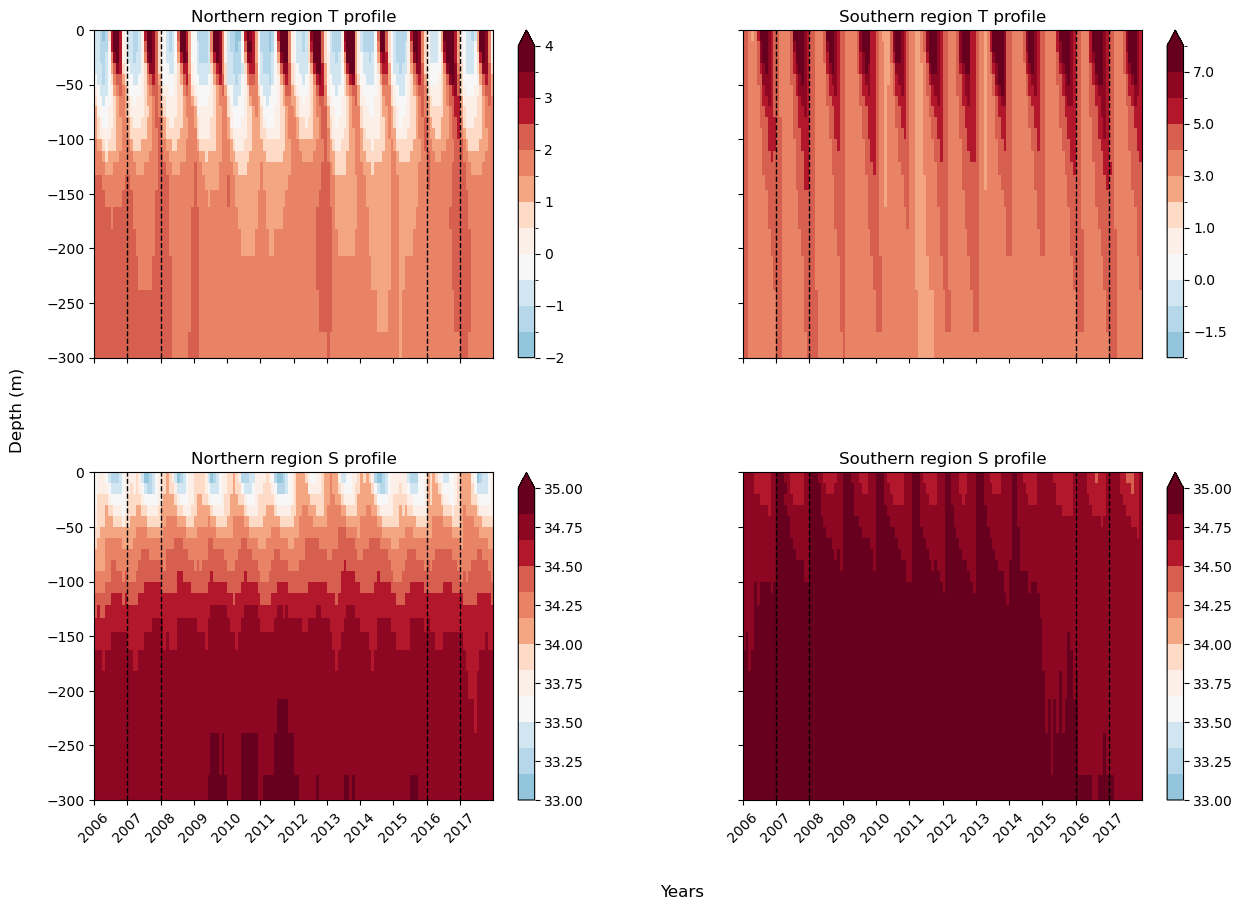

In [63]:
XVc, YVc = np.meshgrid(np.arange(145), mygrid['RF'])

cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(bounds, ncolors=cmap.N, clip=True)

cmap2 = mcolors.ListedColormap(colors)
norm2 = mcolors.BoundaryNorm(bounds2, ncolors=cmap.N, clip=True)

# Make a 2x2 figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)

# X ticks
xtick_positions = np.arange(0, 144, 12)  # Every 12 months
xtick_labels = np.arange(2006, 2018)     # Years from 2006 to 2017

# Find month indices for 2007 and 2016
year0 = 2006
x2007 = (2007 - year0) * 12   # = 12
x2008 = (2008 - year0) * 12   # = 12
x2016 = (2016 - year0) * 12   # = 120
x2017 = (2017 - year0) * 12   # = 120


# --- Temperature profiles ---
cb = axes[0,0].pcolormesh(XVc, YVc, thetaprofile_mskN, cmap=cmap, norm=norm)
axes[0,0].set_ylim(-300,0)
axes[0,0].set_title("Northern region T profile")
axes[0,0].set_xticks(xtick_positions)
axes[0,0].set_xticklabels(xtick_labels, rotation=45)
plt.colorbar(cb, ax=axes[0,0], extend="max")

cb = axes[0,1].pcolormesh(XVc, YVc, thetaprofile_mskS, cmap=cmap2, norm=norm2)
axes[0,1].set_ylim(-300,0)
axes[0,1].set_title("Southern region T profile")
axes[0,1].set_xticks(xtick_positions)
axes[0,1].set_xticklabels(xtick_labels, rotation=45)
plt.colorbar(cb, ax=axes[0,1], extend="max")

# --- Salinity profiles ---
cb = axes[1,0].pcolormesh(XVc, YVc, saltprofile_mskN, cmap=cmap, vmin=33, vmax=35)
axes[1,0].set_ylim(-300,0)
axes[1,0].set_title("Northern region S profile")
axes[1,0].set_xticks(xtick_positions)
axes[1,0].set_xticklabels(xtick_labels, rotation=45)
plt.colorbar(cb, ax=axes[1,0], extend="max")

cb = axes[1,1].pcolormesh(XVc, YVc, saltprofile_mskS, cmap=cmap, vmin=33, vmax=35)
axes[1,1].set_ylim(-300,0)
axes[1,1].set_title("Southern region S profile")
axes[1,1].set_xticks(xtick_positions)
axes[1,1].set_xticklabels(xtick_labels, rotation=45)
plt.colorbar(cb, ax=axes[1,1], extend="max")

# Add dashed lines for 2007 and 2016
for ax in axes.flat:
    ax.axvline(x2007, color="k", linestyle="--", linewidth=1)
    ax.axvline(x2016, color="k", linestyle="--", linewidth=1)
    ax.axvline(x2008, color="k", linestyle="--", linewidth=1)
    ax.axvline(x2017, color="k", linestyle="--", linewidth=1)

# Labels and layout
fig.supxlabel("Years")
fig.supylabel("Depth (m)")
fig.subplots_adjust(left=0.08, wspace=0.3, hspace=0.35)

# plt.savefig(path + "TS_profiles_with_year_lines.png", dpi=300)
plt.show()


## time series heat transport and avg theta and salt through the gates

In [14]:
# Define dimensions
num_years = len(allyears)  # Number of years
gate_labels = ["BSO", "SFJ", "FJNZ","NZRU"]

# Get indices for each gate dynamically
gate_indices = {gate: np.where(gates == label) for gate, label in zip(gate_labels, [1, 2, 3, 4])}

# Initialize dictionaries with variable-length arrays for each gate
theta_timeseries = {gate: np.full((num_years, 12, nz, len(indices[0])), np.nan) for gate, indices in gate_indices.items()}
salt_timeseries = {gate: np.full((num_years, 12, nz, len(indices[0])), np.nan) for gate, indices in gate_indices.items()}

iy = 0  # Counter for year index

for year in allyears:
    print(f"Processing year: {year}")

    # Get time steps for this year
    years = np.array([str(year)])
    times = {year: np.arange(1, 13, 1)}  # All 12 months
    tsstr, datetimes = get_tsteps(times, fnames, dt_aste, startyr, 1, 1)

    # Initialize arrays to hold full-year data
    THETA_all = np.full((len(tsstr), nz, ny, nx), np.nan)
    SALT_all = np.full((len(tsstr), nz, ny, nx), np.nan)

    # Loop over all time steps
    for i in range(len(tsstr)):
        file_name = "state_3d_set1"
        meta_state_3d_set1 = parsemeta(dirState + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_state_3d_set1["fldList"])
        recs = [np.where(fldlist == var)[0][0] for var in ["THETA", "SALT"]]

        read = [int(tsstr[i])]
        THETAi, _, _ = rdmds(os.path.join(dirState, file_name), read, returnmeta=True, rec=recs[0])
        SALTi, _, _ = rdmds(os.path.join(dirState, file_name), read, returnmeta=True, rec=recs[1])

        THETA_all[i, :, :, :] = np.reshape(THETAi, (nz, ny, nx))
        SALT_all[i, :, :, :] = np.reshape(SALTi, (nz, ny, nx))

    

    for gate in gate_labels:
        y_idx, x_idx = gate_indices[gate]  # Get dynamic indices

        # Compute annual averages for each gate
        RAC_gate = np.tile(mygrid['RAC'][np.newaxis,:,:],(nz,1,1))[:,y_idx, x_idx]  # shape (npoints,)
        DRF_gate = DRF3d[:,y_idx,x_idx]
        hfC_gate = hfC[:,y_idx,x_idx]
        volume_gate = RAC_gate * DRF_gate * hfC_gate

        #print(y_idx)
        for depth in range(nz):

            theta_timeseries[gate][iy, :, depth, :] = THETA_all[:, depth, y_idx, x_idx] * volume_gate[depth] 
            salt_timeseries[gate][iy, :, depth, :] = SALT_all[:, depth, y_idx, x_idx] * volume_gate[depth] 

    iy += 1  # Move to the next year

Processing year: 2006
Processing year: 2007
Processing year: 2008
Processing year: 2009
Processing year: 2010
Processing year: 2011
Processing year: 2012
Processing year: 2013
Processing year: 2014
Processing year: 2015
Processing year: 2016
Processing year: 2017


In [16]:
# gates and series
def line_orientation(x, y):
    orientations = np.array([])

    # Iterate through the list of points
    for i in range(1, len(x)):
        if x[i] == x[i - 1] and y[i] != y[i - 1]:
            orientations = np.append(orientations,"V") # vertical line add zonal transp
        elif y[i] == y[i - 1] and x[i] != x[i - 1]:
            orientations = np.append(orientations,"H") # horizontal line add meridional transp
        else:
            orientations = np.append(orientations,"V")  # fill na should be for top of vertical line (ie U)

    # the last one will be the same as the second to last orientation so we can keep consistent sizing
    orientations = np.append(orientations,orientations[-1])

    return orientations
choose_UV_bso = line_orientation(y_bso,x_bso)
choose_UV_sfj = line_orientation(y_sfj,x_sfj)
choose_UV_fjnz = line_orientation(y_fjnz,x_fjnz)
choose_UV_nzru = line_orientation(y_nzru,x_nzru)

choose_UV_bso3d = np.full((nz,ny,nx),'p')
idx = 0
for i,j in zip(y_bso,x_bso):
    choose_UV_bso3d[:,i,j] = np.full(nz,choose_UV_bso[idx])
    idx += 1

choose_UV_sfj3d = np.full((nz,ny,nx),'p')
idx = 0
for i,j in zip(y_sfj,x_sfj):
    choose_UV_sfj3d[:,i,j] = np.full(nz,choose_UV_sfj[idx])
    idx += 1

choose_UV_fjnz3d = np.full((nz,ny,nx),'p')
idx = 0
for i,j in zip(y_fjnz,x_fjnz):
    choose_UV_fjnz3d[:,i,j] = np.full(nz,choose_UV_fjnz[idx])
    idx += 1

choose_UV_nzru3d = np.full((nz,ny,nx),'p')
idx = 0
for i,j in zip(y_nzru,x_nzru):
    choose_UV_nzru3d[:,i,j] = np.full(nz,choose_UV_nzru[idx])
    idx += 1

In [17]:
# Compute distances dynamically for each gate
gate_distances = {}

for gate, (x_gate, y_gate, choose_UV_gate) in zip(gate_labels, [(x_bso, y_bso, choose_UV_bso), 
                                                                (x_sfj, y_sfj, choose_UV_sfj), 
                                                                (x_fjnz, y_fjnz, choose_UV_fjnz),
                                                                (x_nzru, y_nzru, choose_UV_nzru)]):
    distance = np.array([])
    for i in range(len(x_gate)):
        thisy = y_gate[i]
        thisx = x_gate[i]
        this_choose = choose_UV_gate[i]
        
        if this_choose == 'H':
            distance = np.append(distance, mygrid['DYG'][thisy, thisx])
        else:
            distance = np.append(distance, mygrid['DXG'][thisy, thisx])

    gate_distances[gate] = np.cumsum(distance / 1000)  # Convert to km

# Compute depth array
depths = np.cumsum(-mygrid["DRF"])  # Convert to depth in meters

In [22]:
# Define dimensions
num_years = len(allyears)  # Number of years
gate_labels = ["BSO", "SFJ", "FJNZ", "NZRU"]

# Get indices for each gate dynamically
gate_indices = {gate: np.where(gates == label) for gate, label in zip(gate_labels, [1, 2, 3, 4])}

# Selection dictionary for horizontal (ADVx_TH) or vertical (ADVy_TH) transport
choose_UV = {"BSO": choose_UV_bso3d, "SFJ": choose_UV_sfj3d, "FJNZ": choose_UV_fjnz3d, "NZRU": choose_UV_nzru3d}

# Initialize dictionary to store heat transport for each gate
heat_transport_timeseries = {
    gate: np.full((num_years, 12, nz, len(indices[0])), np.nan) for gate, indices in gate_indices.items()
}

iy = 0  # Counter for year index

for year in allyears:
    print(f"Processing year: {year}")

    # Get time steps for this year
    years = np.array([str(year)])
    times = {year: np.arange(1, 13, 1)}  # All 12 months
    tsstr, datetimes = get_tsteps(times, fnames, dt_aste, startyr, 1, 1)

    # Initialize arrays to hold full-year data
    ADVx_TH_all = np.full((len(tsstr), nz, ny, nx), np.nan)
    ADVy_TH_all = np.full((len(tsstr), nz, ny, nx), np.nan)

    # Loop over all time steps
    for i in range(len(tsstr)):
        file_name = "budg3d_hflux_set2"
        meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
        recs = [np.where(fldlist == var)[0][0] for var in ["ADVx_TH", "ADVy_TH"]]

        read = [int(tsstr[i])]
        ADVx_THi, _, _ = rdmds(os.path.join(dirIn, file_name), read, returnmeta=True, rec=recs[0])
        ADVy_THi, _, _ = rdmds(os.path.join(dirIn, file_name), read, returnmeta=True, rec=recs[1])

        ADVx_TH_all[i, :, :, :] = np.reshape(ADVx_THi, (nz, ny, nx))
        ADVy_TH_all[i, :, :, :] = np.reshape(ADVy_THi, (nz, ny, nx))

    # Compute annual averages for each gate
    for gate in gate_labels:
        y_idx, x_idx = gate_indices[gate]  # Get dynamic indices
        UV_selection = choose_UV[gate]  # Determine whether to use H (ADVx_TH) or V (ADVy_TH)
        
        for depth in range(nz):
            advx_seasonal = myparms["rcp"] * ADVx_TH_all[:, depth, y_idx, x_idx]
            advy_seasonal = myparms["rcp"] * ADVy_TH_all[:, depth, y_idx, x_idx]
            
            # Use np.where() for per-gridpoint selection
            if gate == "BSO":
                adv_selected = np.where(UV_selection[depth, y_idx, x_idx] == "H", advx_seasonal, -advy_seasonal)
            elif gate == "SFJ":
                adv_selected = np.where(UV_selection[depth, y_idx, x_idx] == "H", -advx_seasonal, -advy_seasonal)
            else:
                adv_selected = np.where(UV_selection[depth, y_idx, x_idx] == "H", -advx_seasonal, -advy_seasonal)

            heat_transport_timeseries[gate][iy, :, depth, :] = adv_selected


    iy += 1  # Move to the next year

Processing year: 2006
Processing year: 2007
Processing year: 2008
Processing year: 2009
Processing year: 2010
Processing year: 2011
Processing year: 2012
Processing year: 2013
Processing year: 2014
Processing year: 2015
Processing year: 2016
Processing year: 2017


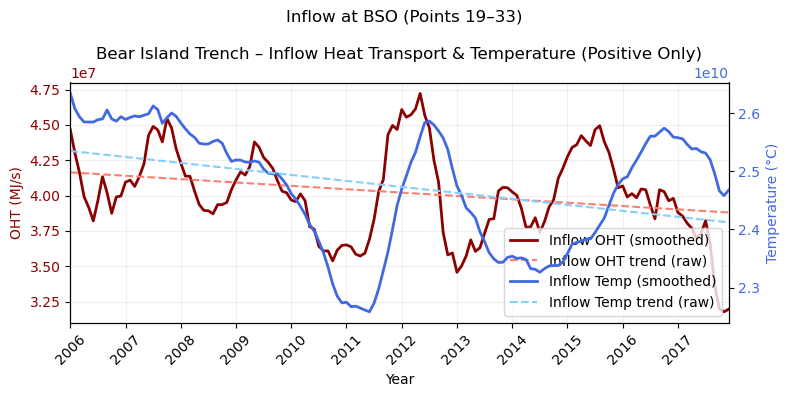

In [49]:
# --- config ---
gate = 'BSO'
gate_slice = slice(19, 34)
window_size = 12  # months

# indices along this gate (C-grid)
y_idx, x_idx = gate_indices[gate]

# --- heat transport (positive-only inflow) ---
Q_W = heat_transport_timeseries[gate][:, :, :, gate_slice]     # (nyears,12,nz,npts), W, signed into basin
Q_MJs = Q_W / 1e6                                              # MJ/s
Q_pos = np.where(Q_MJs > 0, Q_MJs, np.nan)                     # keep inflow only
Q_inflow_monthly = np.nansum(Q_pos, axis=(2, 3)).reshape(-1)   # sum over depth & points -> (T,)

# --- inflow temperature (volume-weighted, same boxes & mask) ---
# pull θ at same boxes
theta = theta_timeseries[gate][:, :, :, gate_slice]            # (nyears,12,nz,npts), °C

# layer volumes along the gate: DRF * hFacC * RAC  (shape: nz x npts)
DRF1d      = np.asarray(mygrid['DRF']).reshape(-1)             # (nz,)
RAC_line   = mygrid['RAC'][y_idx, x_idx][gate_slice]           # (npts,)
hFacC_line = mygrid['hFacC'][:, y_idx, x_idx][:, gate_slice]   # (nz, npts)
vol_layer  = (DRF1d[:, None] * hFacC_line * RAC_line[None, :]) # (nz, npts)

# broadcast to time dims
vol4D = vol_layer[None, None, :, :]                            # (1,1,nz,npts)

# inflow mask: use same positive-heat criterion
inflow_mask = Q_MJs > 0                                        # (nyears,12,nz,npts)

# if your theta_timeseries already stores θ*volume, undo it:
# theta = theta / np.where(vol4D > 0, vol4D, np.nan)

# volume-weighted θ for inflow only
num = np.nansum(theta * vol4D * inflow_mask, axis=(2, 3))
den = np.nansum(           vol4D * inflow_mask, axis=(2, 3))
T_inflow_monthly = (num / np.where(den > 0, den, np.nan)).reshape(-1)   # (T,)

# --- smooth & trends ---
Q_smooth = pd.Series(Q_inflow_monthly).rolling(window=window_size, center=True, min_periods=1).mean()
T_smooth = pd.Series(T_inflow_monthly).rolling(window=window_size, center=True, min_periods=1).mean()

Tlen = Q_inflow_monthly.size
time = np.arange(Tlen)

# robust linear fits ignoring NaNs
fin_Q = np.isfinite(Q_inflow_monthly)
fin_T = np.isfinite(T_inflow_monthly)
trend_Q = np.poly1d(np.polyfit(time[fin_Q], Q_inflow_monthly[fin_Q], 1))(time) if np.any(fin_Q) else np.full(Tlen, np.nan)
trend_T = np.poly1d(np.polyfit(time[fin_T], T_inflow_monthly[fin_T], 1))(time) if np.any(fin_T) else np.full(Tlen, np.nan)

# x ticks from allyears
nyears = heat_transport_timeseries[gate].shape[0]
years_for_plot = np.asarray(allyears[:nyears], dtype=int)
xtick_positions = np.arange(0, nyears*12, 12)
xtick_labels = years_for_plot

# --- plot ---
fig, ax1 = plt.subplots(figsize=(8, 4))

# heat (left axis)
ax1.plot(time, Q_smooth, color="darkred", lw=2, label="Inflow OHT (smoothed)")
ax1.plot(time, trend_Q, color="salmon", lw=1.5, ls="--", label="Inflow OHT trend (raw)")
ax1.set_ylabel("OHT (MJ/s)", color="darkred")
ax1.tick_params(axis='y', labelcolor="darkred")
ax1.set_title("Bear Island Trench – Inflow Heat Transport & Temperature (Positive Only)")
ax1.set_xticks(xtick_positions)
ax1.set_xticklabels(xtick_labels, rotation=45)
ax1.set_xlim(0, Tlen-1)
ax1.grid(alpha=0.2)

# temperature (right axis)
ax2 = ax1.twinx()
ax2.plot(time, T_smooth, color="royalblue", lw=2, label="Inflow Temp (smoothed)")
ax2.plot(time, trend_T, color="lightskyblue", lw=1.5, ls="--", label="Inflow Temp trend (raw)")
ax2.set_ylabel("Temperature (°C)", color="royalblue")
ax2.tick_params(axis='y', labelcolor="royalblue")

# legend
l1, lab1 = ax1.get_legend_handles_labels()
l2, lab2 = ax2.get_legend_handles_labels()
ax1.legend(l1 + l2, lab1 + lab2, loc="lower right")

ax1.set_xlabel("Year")
plt.suptitle(f"Inflow at {gate} (Points {gate_slice.start}–{gate_slice.stop-1})", fontsize=12)
plt.tight_layout()
plt.show()


## we need to look at the temperature and salt trends through the BSO because this does not make sense